In [ ]:
!pip install datasets
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


dataset = load_dataset("pszemraj/goodreads-bookgenres")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-1ddc9bde2cb8ca(…):   0%|          | 0.00/5.44M [00:00<?, ?B/s]

data/validation-00000-of-00001-c69c3deb9(…):   0%|          | 0.00/671k [00:00<?, ?B/s]

data/test-00000-of-00001-35cf4a77f73c1e6(…):   0%|          | 0.00/673k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7914 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/989 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/990 [00:00<?, ? examples/s]

Carregando o dataset Goodreads Book Genres e convertendo para DataFrame.

Observa-se que o dataset possui três colunas principais:
- 'Title'       : título do livro
- 'Description' : resumo ou descrição do livro, que será usado para análise textual
- 'Genres'      : vetor binário de 18 posições indicando a presença (1) ou ausência (0) de cada gênero literário


In [ ]:
# Carregando o dataset
dataset = load_dataset("pszemraj/goodreads-bookgenres")

# Converter para DataFrame pandas para facilitar análise
df_train = pd.DataFrame(dataset['train'])
df_val = pd.DataFrame(dataset['validation'])
df_test = pd.DataFrame(dataset['test'])

# Visualizar as primeiras linhas
df_train.head()


,Book,Description,Genres
0,The Last of the Mohicans (The Leatherstocking ...,The wild rush of action in this classic fronti...,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ..."
1,A Room of One's Own,A Room of One's Own is an extended essay by Vi...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,The Daughter Of Kurdland: A Life Dedicated to ...,WINNER of the PACEM IN TERRIS PEACE AND FREEDO...,"[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,A Good Girl's Guide to Murder (A Good Girl's G...,"The case is closed. Five years ago, schoolgirl...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,Hocus Pocus,Trying to outwit the spell only makes matters ...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ..."


Sumário dos dados do dataset:

In [ ]:
# Verificar colunas e tipos
df_train.info()

# Exibir algumas descrições e gêneros
for i in range(3):
    print("Descrição:", df_train['Description'][i])
    print("Gêneros:", df_train['Genres'][i])
    print("-----")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7914 entries, 0 to 7913
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Book         7914 non-null   object
 1   Description  7914 non-null   object
 2   Genres       7914 non-null   object
 3   num_words    7914 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 247.4+ KB
Descrição: The wild rush of action in this classic frontier adventure story has made The Last of the Mohicans the most popular of James Fenimore Cooper's Leatherstocking Tales. Deep in the forests of upper New York State, the brave woodsman Hawkeye (Natty Bumppo) and his loyal Mohican friends Chingachgook and Uncas become embroiled in the bloody battles of the French and Indian War. The abduction of the beautiful Munro sisters by hostile savages, the treachery of the renegade brave Magua, the ambush of innocent settlers, and the thrilling events that lead to the final tragic confrontation 



A coluna num_words mostra que a maioria das descrições possui entre 100 e 200 palavras (mediana = 142), mas existem textos muito curtos (1 palavra) e alguns extremamente longos (até 3583 palavras), ou seja, há outliers.

Para preparar o modelo de IA:

* Podemos **truncar ou padronizar** os textos longos para reduzir o impacto dos outliers.
* Textos muito curtos podem ser analisados separadamente ou filtrados, apenas removendo eles.





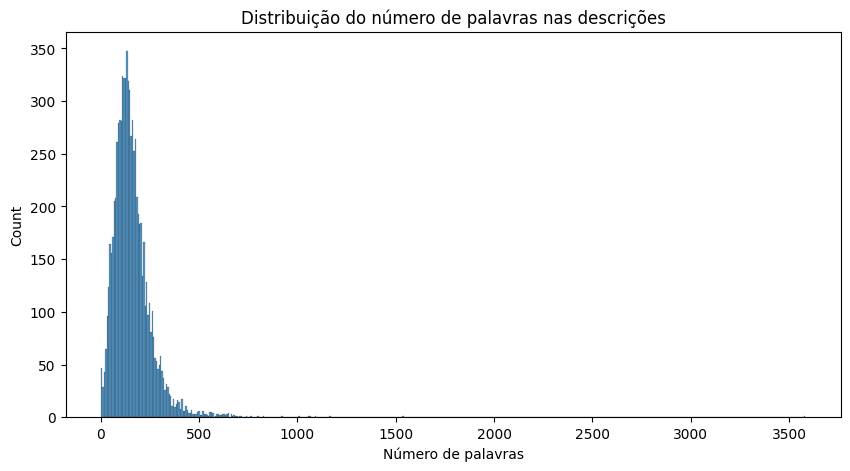

In [ ]:
# Comprimento das descrições (número de palavras)
df_train['num_words'] = df_train['Description'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,5))
sns.histplot(df_train['num_words'], bins=500)
plt.title("Distribuição do número de palavras nas descrições")
plt.xlabel("Número de palavras")

plt.show()

In [ ]:
df_train['num_words'].describe()

,num_words
count,7914.000000
mean,159.130655
std,103.611668
min,1.000000
25%,98.000000
50%,142.000000
75%,198.000000
max,3583.000000


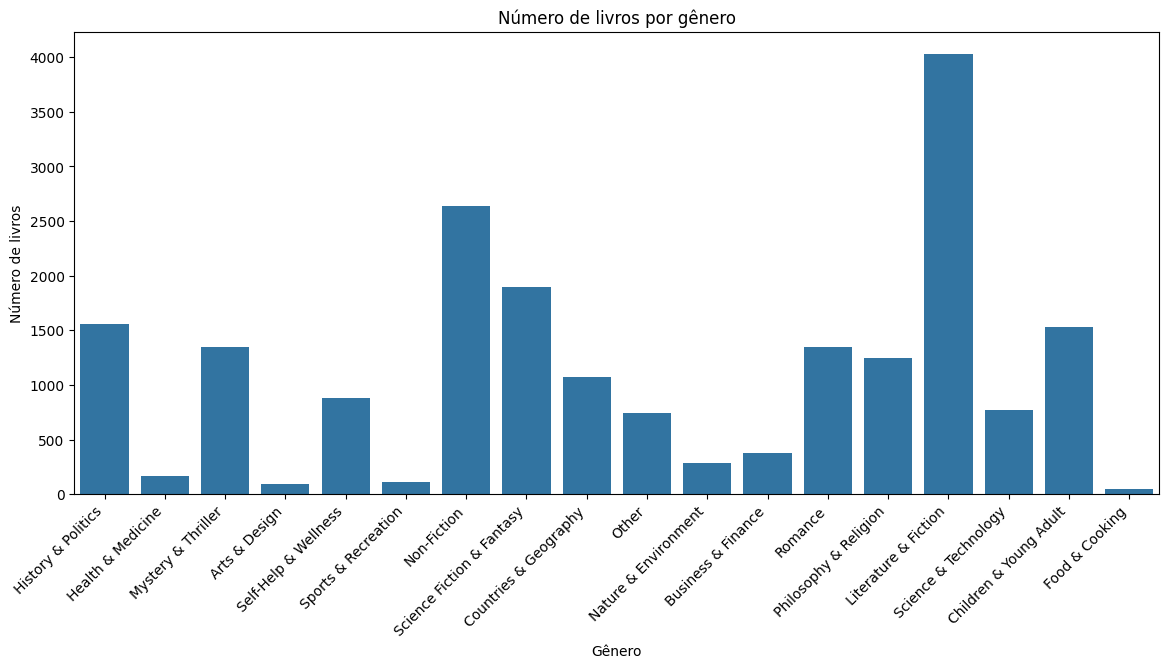

In [ ]:
genre_mapping = {
    0: 'History & Politics',
    1: 'Health & Medicine',
    2: 'Mystery & Thriller',
    3: 'Arts & Design',
    4: 'Self-Help & Wellness',
    5: 'Sports & Recreation',
    6: 'Non-Fiction',
    7: 'Science Fiction & Fantasy',
    8: 'Countries & Geography',
    9: 'Other',
    10: 'Nature & Environment',
    11: 'Business & Finance',
    12: 'Romance',
    13: 'Philosophy & Religion',
    14: 'Literature & Fiction',
    15: 'Science & Technology',
    16: 'Children & Young Adult',
    17: 'Food & Cooking'
}


# Contagem dos gêneros
genre_counts = np.sum(df_train['Genres'].tolist(), axis=0)

# Criar DataFrame com nomes reais
genre_df = pd.DataFrame({
    'Genre': [genre_mapping[i] for i in range(18)],
    'Count': genre_counts
})

# Plot
plt.figure(figsize=(14,6))
sns.barplot(x='Genre', y='Count', data=genre_df)
plt.xticks(rotation=45, ha='right')
plt.title("Número de livros por gênero")
plt.xlabel("Gênero")
plt.ylabel("Número de livros")
plt.show()



Observando o gráfico de **número de livros por gênero**, percebemos que **a distribuição não é uniforme**: alguns gêneros possuem muitos exemplos (ex.: *Literature & Fiction*), enquanto outros têm muito poucos (ex.: *Food & Cooking*).

**Implicações para o modelo de IA**:

* Gêneros com mais exemplos tendem a ser aprendidos melhor, enquanto gêneros com poucos textos podem ser **sub-representados**.
* Isso pode gerar **viés no modelo**, favorecendo gêneros mais comuns.

**Como lidar com essa desigualdade de classes**:

1. **Amostragem balanceada**:

   * *Oversampling* dos gêneros minoritários (duplicar exemplos ou gerar dados sintéticos).
   * *Undersampling* dos gêneros majoritários (reduzir o número de exemplos para igualar).
2. **Pesos de classe**:

   * Durante o treinamento, aplicar **pesos maiores** para gêneros minoritários na função de perda, fazendo o modelo "prestar mais atenção" a eles.
3. **Data augmentation textual**:

   * Gerar novas descrições para gêneros com poucos exemplos usando técnicas de NLP (paráfrases, sinônimos, modelos de linguagem).

Dessa forma, conseguimos **reduzir o viés do modelo** e melhorar a performance em todos os gêneros, não apenas nos mais representados.




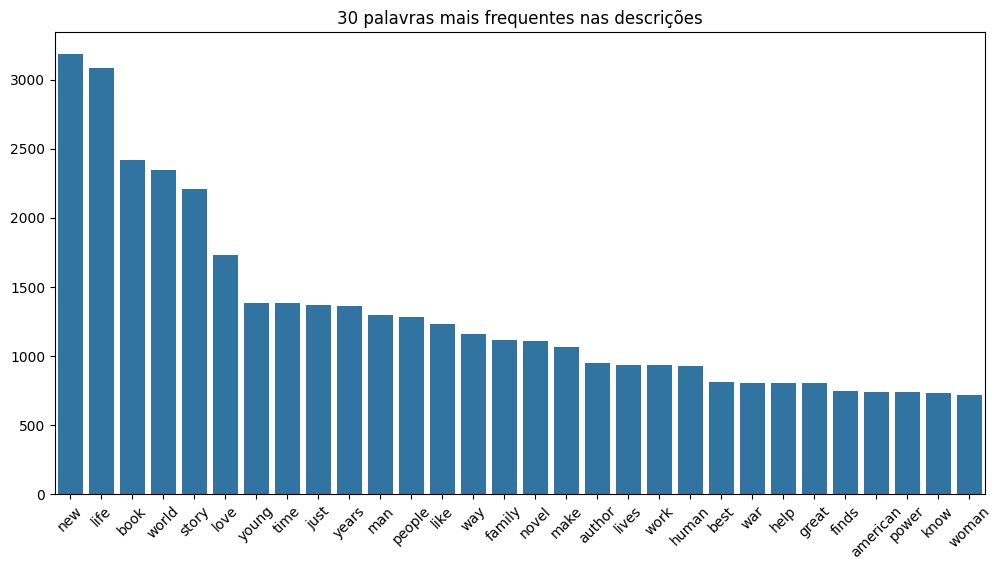

In [ ]:
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

all_text = ' '.join(df_train['Description'].dropna()).lower().split()
all_text = [word for word in all_text if word.isalpha() and word not in ENGLISH_STOP_WORDS]

counter = Counter(all_text)
most_common = counter.most_common(30)

words, counts = zip(*most_common)
plt.figure(figsize=(12,6))
sns.barplot(x=list(words), y=list(counts))
plt.xticks(rotation=45)
plt.title("30 palavras mais frequentes nas descrições")
plt.show()



O gráfico mostra as 30 palavras mais frequentes nas descrições dos livros. Muitas dessas palavras são muito comuns (como “book”, “story”, “novel”), e talvez **não contribuam significativamente para diferenciar os gêneros.

Para ter em mente ao treinar o modelo:

* Palavras muito frequentes podem gerar **ruído** e nem sempre ajudam na decisão do gênero.
* Pode ser interessante explorar **palavras mais representativas por gênero**, ou combinações de palavras (bigramas/trigramas), para capturar termos que realmente diferenciam os livros.





Total de livros: 7914
Livros com mais de um gênero: 6227
Porcentagem: 78.68%


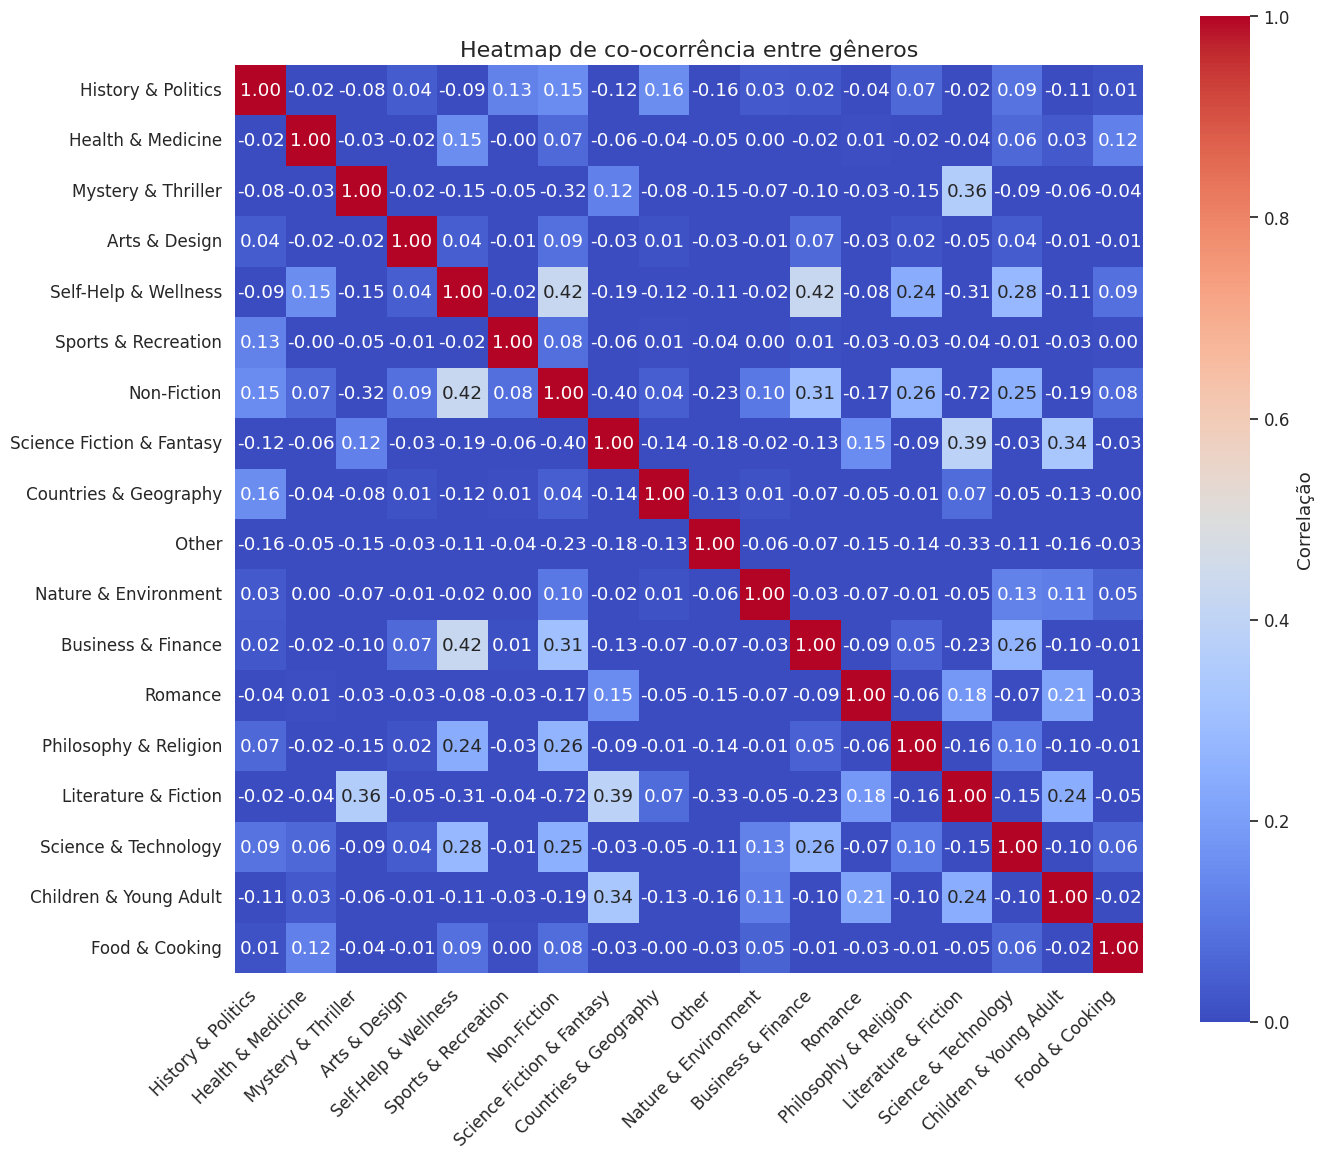

In [ ]:
# Contar quantos gêneros cada livro possui
df_train['num_genres'] = df_train['Genres'].apply(lambda x: sum(x))

# Ver quantos livros têm mais de 1 gênero
multi_genre_count = (df_train['num_genres'] > 1).sum()
total_books = len(df_train)

print(f"Total de livros: {total_books}")
print(f"Livros com mais de um gênero: {multi_genre_count}")
print(f"Porcentagem: {multi_genre_count/total_books*100:.2f}%")


genre_corr = pd.DataFrame(df_train['Genres'].tolist()).corr()

plt.figure(figsize=(14,12))
sns.set(font_scale=1.1)

ax = sns.heatmap(
    genre_corr,
    vmin=0, vmax=1,
    annot=True, fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'label': 'Correlação'},
    xticklabels=[genre_mapping[i] for i in range(18)],
    yticklabels=[genre_mapping[i] for i in range(18)],
    square=True  # garante quadrados perfeitos
)

# Ajustar ticks para ficarem nos cantos
ax.set_xticks([i + 0.5 for i in range(len(genre_mapping))])
ax.set_yticks([i + 0.5 for i in range(len(genre_mapping))])
ax.set_xticklabels([genre_mapping[i] for i in range(18)], rotation=45, ha='right')
ax.set_yticklabels([genre_mapping[i] for i in range(18)], rotation=0)

plt.title("Heatmap de co-ocorrência entre gêneros", fontsize=16)
plt.tight_layout()
plt.show()



/tmp/ipython-input-2942608621.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='num_genres', data=df_train, palette='viridis')


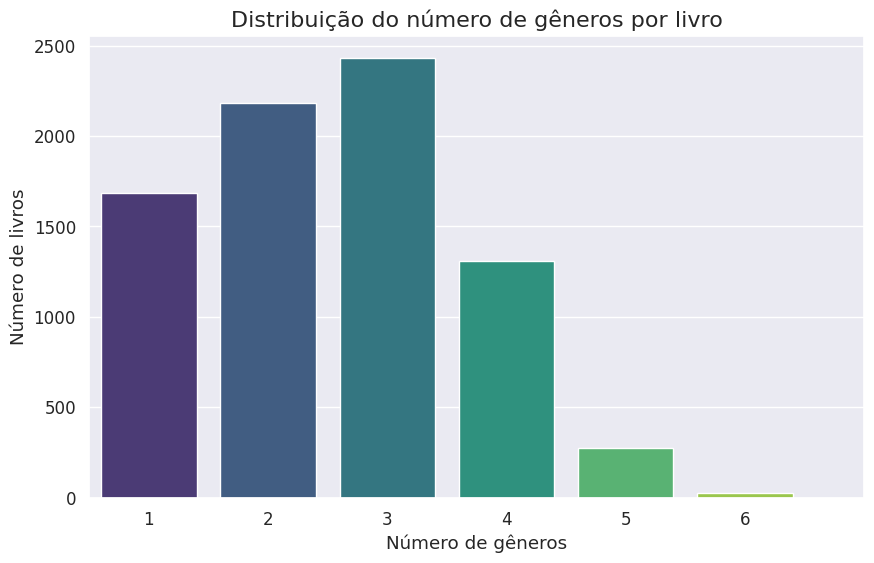

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.countplot(x='num_genres', data=df_train, palette='viridis')
plt.title("Distribuição do número de gêneros por livro", fontsize=16)
plt.xlabel("Número de gêneros")
plt.ylabel("Número de livros")
plt.xticks(range(df_train['num_genres'].max()+1))
plt.show()



1. **Grande maioria dos livros é multilabel:**

   * 78,7% dos livros têm mais de um gênero, o que confirma que não se trata de um problema de classificação simples, mas de classificação multilabel.

2. **Sobreposição natural de gêneros (“overlap”):**

   * Alguns gêneros específicos estão subconjuntos de outros mais gerais, por exemplo:

     * Todo *Science Fiction & Fantasy* provavelmente também pertence a *Literature & Fiction*.
   * Isso significa que há **dependências entre as classes** que o modelo pode aproveitar.
   * Ignorar essas relações pode fazer o modelo cometer “erros” que, na verdade, não são erros reais do ponto de vista semântico.

3. **Implicações para treinamento:**

   * Talvez seja útil **considerar hierarquias ou relações entre gêneros**, por exemplo: modelar *Literature & Fiction* como uma classe geral e os outros como subgêneros.
   * Alternativamente, **não tratar cada gênero como completamente independente**, mas usar técnicas multilabel que lidam bem com sobreposição de classes.


